In [0]:
import pandas as pd
import io
from google.colab import files
def load_housing_data():
  uploaded=files.upload()
  csv=pd.read_csv(io.BytesIO(uploaded["housing.csv"]),thousands=',')
  return csv
housing = load_housing_data()

Saving housing.csv to housing (2).csv


In [0]:
print(housing.head())
print(housing.info())
print(housing["ocean_proximity"].value_counts())
print(housing.describe())

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)

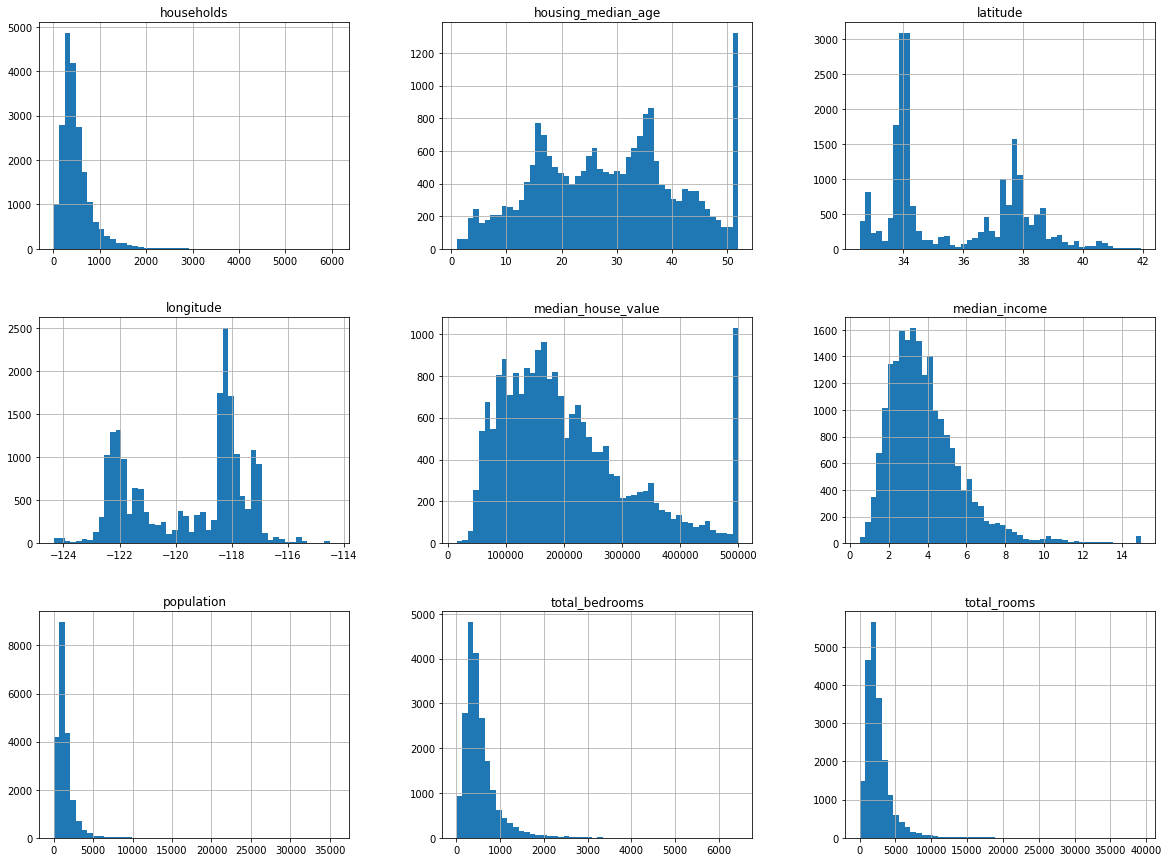

In [0]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)  #create 5 income categories
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

print(housing["income_cat"].value_counts() / len(housing))
for set in (strat_train_set, strat_test_set):
  set.drop(["income_cat"], axis=1, inplace=True)
housing = strat_train_set.copy()

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


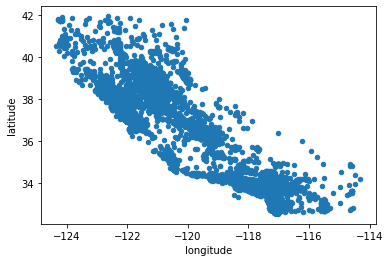

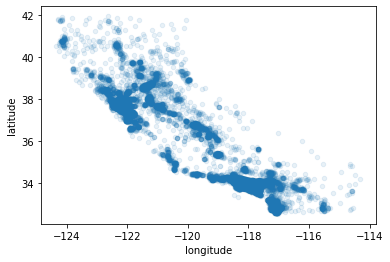

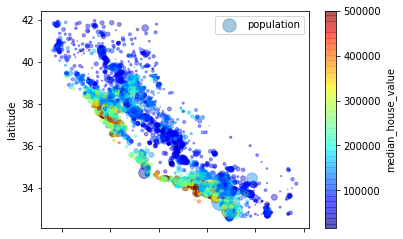

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a5d115da0>


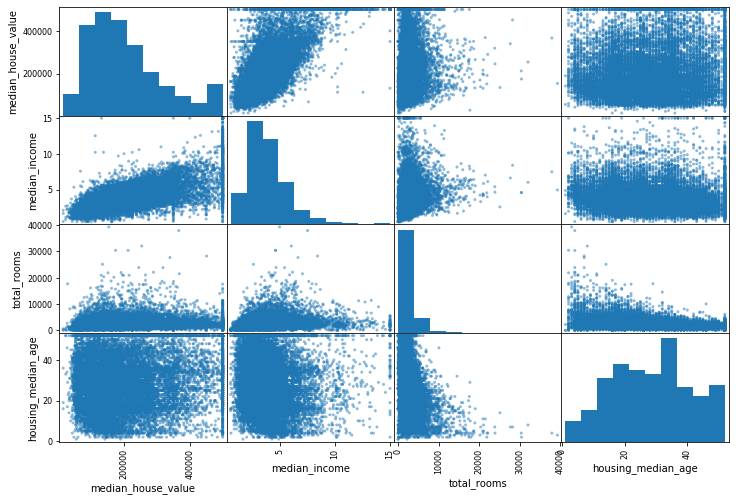

In [0]:
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
print(scatter_matrix(housing[attributes], figsize=(12, 8)))

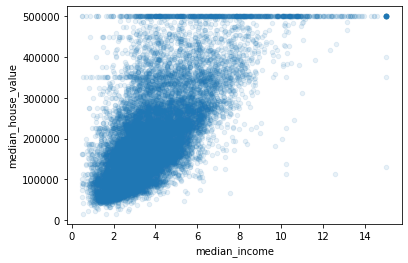

In [0]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1) #The most promising attribute to predict the median house value is the median income

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]     #additional features
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy() #keep the labels for testing
housing_num = housing.drop("ocean_proximity", axis=1) #drop non-numeric attributes

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin   #custom transformer class for adding the additional features
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin  #select the numeric and categorical attributes seperately

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
print(num_attribs,cat_attribs)
#pipeline the transformations
num_pipeline = Pipeline([   #numberic attributes
('selector', DataFrameSelector(num_attribs)),  #select numeric attributes
('imputer', SimpleImputer(strategy="median")),   #fill missing values with median
('attribs_adder', CombinedAttributesAdder()),   #add the additional attributes
('std_scaler', StandardScaler()),      #nomalize using standardization, subtract mean and divide by variance so all have zero mean     
])
cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)), #select categorical attributes
('label_binarizer', OneHotEncoder()),          #convert to onehot encoding
])
full_pipeline = FeatureUnion(transformer_list=[        #merge the results after transformations
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] ['ocean_proximity']


In [0]:
print(housing.info)
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)
print(housing_prepared.shape)

<bound method DataFrame.info of        longitude  latitude  ...  median_income  ocean_proximity
17606    -121.89     37.29  ...         2.7042        <1H OCEAN
18632    -121.93     37.05  ...         6.4214        <1H OCEAN
14650    -117.20     32.77  ...         2.8621       NEAR OCEAN
3230     -119.61     36.31  ...         1.8839           INLAND
3555     -118.59     34.23  ...         3.0347        <1H OCEAN
...          ...       ...  ...            ...              ...
6563     -118.13     34.20  ...         4.9312           INLAND
12053    -117.56     33.88  ...         2.0682           INLAND
13908    -116.40     34.09  ...         3.2723           INLAND
11159    -118.01     33.82  ...         4.0625        <1H OCEAN
15775    -122.45     37.77  ...         3.5750         NEAR BAY

[16512 rows x 9 columns]>
  (0, 0)	-1.1560428086829155
  (0, 1)	0.7719496164846016
  (0, 2)	0.7433308916510305
  (0, 3)	-0.49323393384425046
  (0, 4)	-0.4454382074687401
  (0, 5)	-0.6362114070375079


In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) #train a linear regression model 


some_data = housing.iloc[:5] #do prediction on some random samples
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) #you need to pre-process the test data before prediction

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.6045739  317768.80685738 210956.4333894   59218.98914474
 189747.55850345]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [0]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)



Scores: [66782.73843011 66960.11807389 70347.95260788 74739.57052871
 68031.13393481 71193.84184257 64969.63058283 68281.61137441
 71552.91569811 67665.10082565]
Mean: 69052.46138989963
Standard deviation: 2731.674009845252


In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


In [78]:
from sklearn.model_selection import GridSearchCV #use grid search for fixing hyperparameters of random forest

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [80]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47730.22690385927
